# Prediction of Tanzanian water pumps functional status

This study will focus on identifying the functional status (functional, needs repair or non-functional) of Tanzanian water pumps. The possible explanatory variables will be location, construction year, funder, type of extraction, water quality and quantity, population using it and management organization.

I picked up this challenge from the [DrivenData](https://www.drivendata.org/) competitions list because it shows a direct and pratical application of how statistical analysis can help improve services and products quality. And as an engineer, those goals will be definitely the basis of any data science case I will have to solve. Moreover, as lots of possible explanatory variables are available, this will give me the chance to apply advance tools I learnt during the [Data Analysis and Interpretation online Specialization](https://www.coursera.org/specializations/data-analysis).

Predicting accurately the water pumps functional status will help planning maintenance earlier. That in turn will increase the availability of the water point and thus the quality of life for the people depending on those water supplies.

## Methods

### Sample

The database contains 74,250 records of water points information from the Tanzania Ministry of Water. The records were made between October 2002 and December 2013.

### Measures

The functional status of the water points are categorized in three groups: functional, functional needs repair and non functional. As a hierarchy can be associated to those category, a quantitative variable will be created associating the value 0 as non functional, 1 as functional needs repair and 2 as functional.

The potential predictors will be:

- The amount of water available; missing data are coded as 0, they will be coded as NaN.
- The organization having funded the well; from the various actors, the 9 most funders will be kept and the others will be gathered in an unique category.
- The installer of the well; from the various actors, the 9 most funders will be kept and the others will be gathered in an unique category.
- The GPS coordinates (height, longitude and latitude); missing data are coded as 0, they will be coded as NaN.
- The geographic water basin
- The geographic region
- The population around the well; missing data are coded as 0, they will be coded as NaN.
- Organization of public meeting at the water point; dichotomic variable (True/False)
- The operator of the waterpoint
- The management of the waterpoint
- Is the waterpoint is permitted?
- Year the waterpoint was constructed; missing data are coded as 0, they will be coded as NaN.
- The kind of extraction the waterpoint uses
- How payment are handled?
- The quality of the water
- The quantity of the water
- The source of the water
- The type of water point

As the Python package sklearn cannot handle non-binary categorical variables, those variables will be expanded in as much new dichotomic variables as there are categories.

### Analyses

The distributions of the response and explanatory variables will be evaluated by looking at the frequency tables for categorical variables and by calculating statistical values (mean, standard deviation, minimum and maximum) for quantitative variables.

Bivariate associations will be analyzed by visualizing scatter and box plots. And possible bivariate associations between the explanatory variables and the functional status of the water point will be tested using Pearson correlation (when testing a quantitative variable) or the Analysis of variance, ANOVA, when testing a categorical variable.

The random forest method will be applied to identify the best subset of predictors. The DrivenData competition has split the database in a training set containing 80% of the records and 20% are kept for testing by submission on the website. As multiple submissions are allowed for the competition, the accuracy of the model will be tested by submitting the prediction carried out on the test data.


> This Jupyter notebook will be the basis for the final report for the [Data Analysis and Interpretation Specialization](https://www.coursera.org/specializations/data-analysis)

In [1]:
##### HERE STOP THE ASSIGNEMENT #####

In [1]:
from IPython.display import display, display_markdown
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import ensemble, preprocessing, cross_validation
import qgrid
qgrid.nbinstall(overwrite=True)

In [2]:
training_data = pd.read_csv('training_set_values.csv', index_col=0)
training_label = pd.read_csv('training_set_labels.csv', index_col=0)

test_data = pd.read_csv('test_set_values.csv', index_col=0)

In [3]:
data = training_label.join(training_data)
data.head()

,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,
69572,functional,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
8776,functional,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
34310,functional,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
67743,non functional,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
19728,functional,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [4]:
# Data management
data['status'] = data.status_group.map({'non functional':0, 
                                        'functional needs repair':1, 
                                        'functional':2})

# As lots of waterpoints are missing a value for amount_tsh. For that field the missing
# data will be replaced by the mean data to drop less data for the model fit
imp = preprocessing.Imputer(missing_values=0, strategy='mean')
imp.fit(data['amount_tsh'].values.reshape(-1, 1))
data['water amount'] = imp.transform(data['amount_tsh'].values.reshape(-1, 1)).ravel()

imp = preprocessing.Imputer(missing_values=0, strategy='median')
imp.fit(data['construction_year'].values.reshape(-1, 1))
data['construction_year'] = imp.transform(data['construction_year'].values.reshape(-1, 1)).ravel()

imp = preprocessing.Imputer(missing_values=0, strategy='mean')
imp.fit(data['gps_height'].values.reshape(-1, 1))
data['height'] = imp.transform(data['gps_height'].values.reshape(-1, 1)).ravel()

# Recode missing data as NaN
for field in ('longitude', 'latitude'):
    data[field] = data[field].map(lambda x: x if x else pd.np.nan)

def group_installer(data):
    def gather_installer(x):
        installer_map = {
            'organisation' : ('bank', 'msf', 'wwf', 'unicef', 'unisef', 'oxfam', 'oxfarm', 'club', 'care', 'without', 'faim', 'rain', 'red', 'angels', 'fundat', 'foundation'),
            'church' : ('church', 'churc', 'rcchurch', 'roman', 'missionsry', 'lutheran', 'islamic', 'islam', 'vision'),
            'private' : ('consulting', 'engineer', 'private', 'ltd', 'co.ltd', 'contractor', 'enterp', 'enterpr', 'company', 'contract'),
            'community' : ('village', 'community', 'communit', 'district', 'council', 'commu', 'villigers', 'villagers'),
            'government' : ('government', 'gov', 'govt', 'gover', 'gove', 'governme', 'ministry'),
            'other' : ('0', 'nan', 'known', 'other', 'unknown'), # Group 'unknown' data with 'other' as finally this means the same for interpretation
            'danida' : ('danida', 'danid'),
            'foreign government' : ('netherlands', 'germany', 'european')
        }

        for substr in x.split():
            for subsubstr in substr.split('/'):
                for key in installer_map:
                    if subsubstr in installer_map[key]:
                        return key

        return x
    
    lower_data = data.map(lambda x: str(x).lower())
    tmp_data = lower_data.map(gather_installer)
    top10 = list(tmp_data.value_counts()[:10].index)
    
    return tmp_data.map(lambda x: x if x in top10 else 'other')

data['installer'] = group_installer(data.installer)
data['funder'] = group_installer(data.funder)

In [5]:
data.shape

(59400, 43)

In [6]:
# Extract predictors and convert categorical variables in dichotomic variables
predictors_name = ['water amount', 'height', 'longitude', 'latitude',
                   'basin', 'region', 'population', 'public_meeting', 'management_group',
                   'permit', 'construction_year', 'extraction_type_class', 'payment_type',
                   'quality_group', 'quantity_group', 'source_type', 'waterpoint_type_group',
                   'installer', 'funder']

categorical_predictors = ('basin', 'region', 'management_group', 'extraction_type_class', 
                          'payment_type', 'quality_group', 'quantity_group', 
                          'source_type', 'waterpoint_type_group', 'installer', 'funder')

predictors = pd.DataFrame()
for name in predictors_name:
    if name in categorical_predictors:
        classes = data[name].unique()
        deployed_categories = preprocessing.label_binarize(data[name], classes=classes)
        # Avoid class name collision
        classe_names = list()
        for c in classes:
            if c in predictors.columns:
                classe_names.append('_'.join((c, name)))
            else:
                classe_names.append(c)
        
        tmp_df = pd.DataFrame(deployed_categories, 
                              columns=classe_names, 
                              index=data.index)
        predictors = predictors.join(tmp_df)
    else:
        predictors[name] = data[name]

predictors_columns = predictors.columns
        
clean_data = predictors.join(data['status']).dropna()
predictors = clean_data[predictors_columns]

In [7]:
predictors.shape

(51827, 101)

# Univariate distribution

## Categorical variables distribution

## Status group distribution

,functional,non functional,functional needs repair
status_group,32259,22824,4317


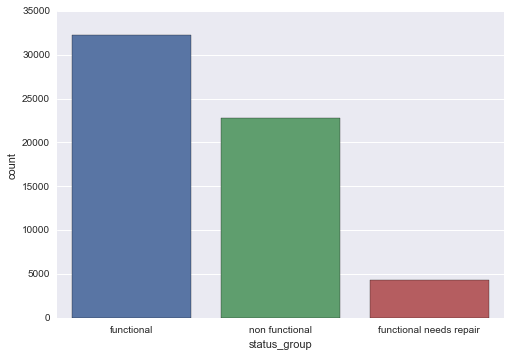

## Basin distribution

,Lake Victoria,Pangani,Rufiji,Internal,Lake Tanganyika,Wami / Ruvu,Lake Nyasa,Ruvuma / Southern Coast,Lake Rukwa
basin,10248,8940,7976,7785,6432,5987,5085,4493,2454


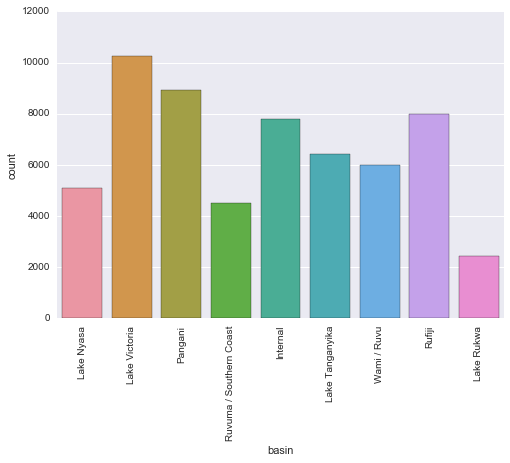

## Region distribution

,Iringa,Shinyanga,Mbeya,Kilimanjaro,Morogoro,Arusha,Kagera,Mwanza,Kigoma,Ruvuma,Pwani,Tanga,Dodoma,Singida,Mara,Tabora,Rukwa,Mtwara,Manyara,Lindi,Dar es Salaam
region,5294,4982,4639,4379,4006,3350,3316,3102,2816,2640,2635,2547,2201,2093,1969,1959,1808,1730,1583,1546,805


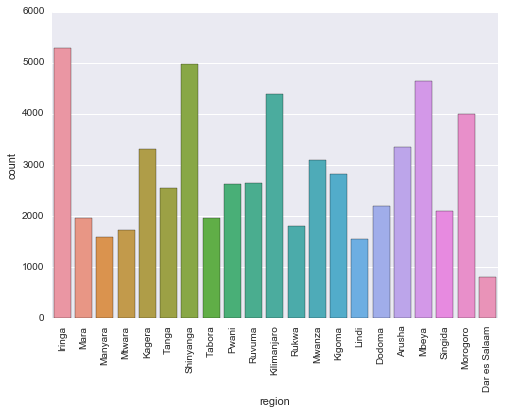

## Management group distribution

,user-group,commercial,parastatal,other,unknown
management_group,52490,3638,1768,943,561


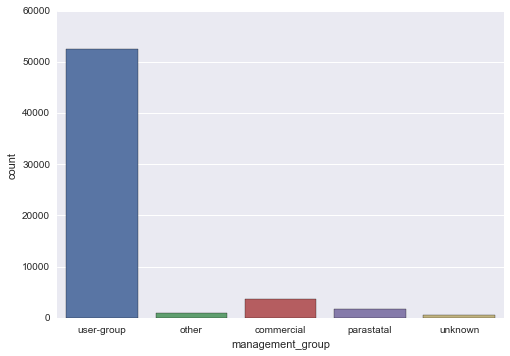

## Extraction type class distribution

,gravity,handpump,other,submersible,motorpump,rope pump,wind-powered
extraction_type_class,26780,16456,6430,6179,2987,451,117


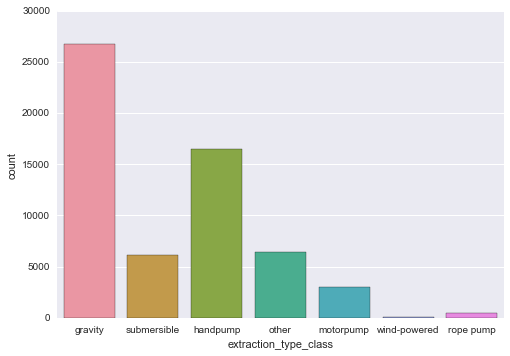

## Payment type distribution

,never pay,per bucket,monthly,unknown,on failure,annually,other
payment_type,25348,8985,8300,8157,3914,3642,1054


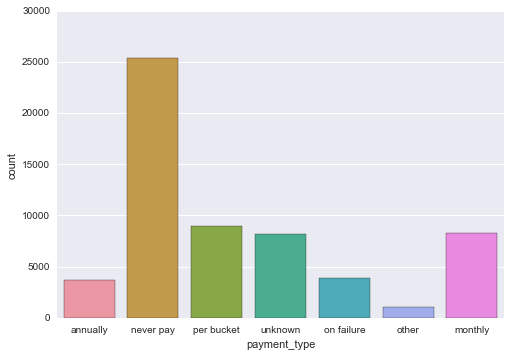

## Quality group distribution

,good,salty,unknown,milky,colored,fluoride
quality_group,50818,5195,1876,804,490,217


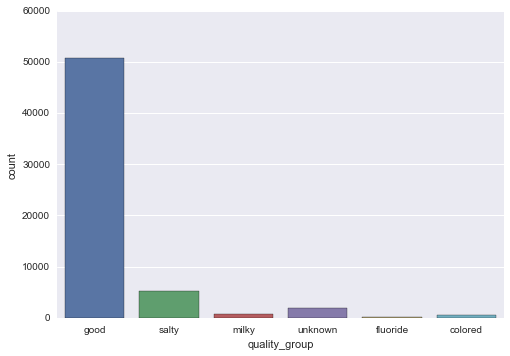

## Quantity group distribution

,enough,insufficient,dry,seasonal,unknown
quantity_group,33186,15129,6246,4050,789


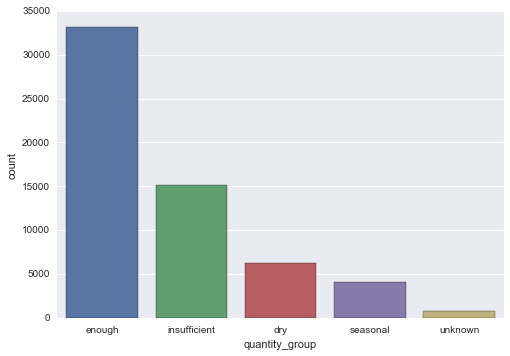

## Source type distribution

,spring,shallow well,borehole,river/lake,rainwater harvesting,dam,other
source_type,17021,16824,11949,10377,2295,656,278


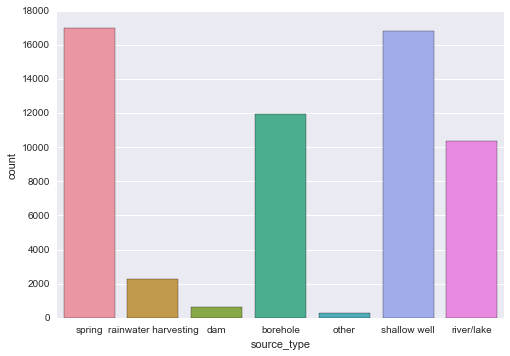

## Waterpoint type group distribution

,communal standpipe,hand pump,other,improved spring,cattle trough,dam
waterpoint_type_group,34625,17488,6380,784,116,7


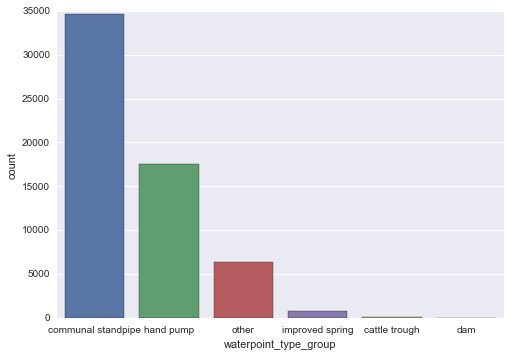

## Installer distribution

,other,dwe,government,community,danida,hesawa,church,rwe,organisation,kkkt
installer,27149,17405,3713,3579,1675,1395,1265,1206,1103,910


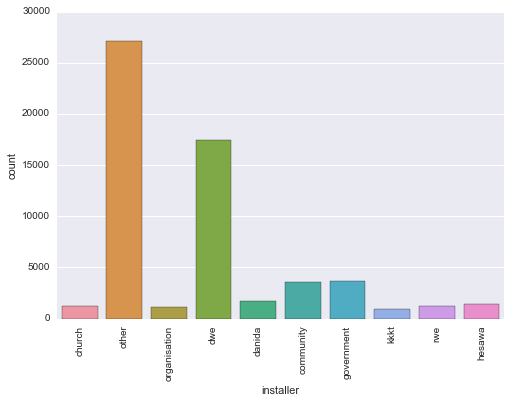

## Funder distribution

,other,government,organisation,danida,church,hesawa,community,rwssp,foreign government,kkkt
funder,32605,9965,3353,3124,2511,2202,1670,1374,1309,1287


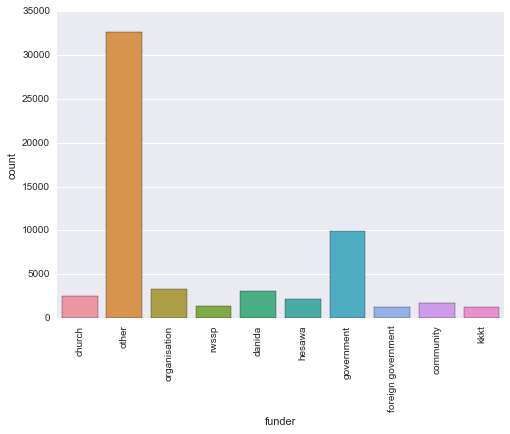

## Public meeting distribution

,True,False,nan
public_meeting,51011,5055,3334


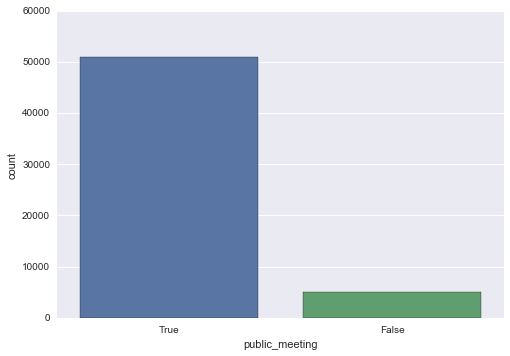

## Permit distribution

,True,False,nan
permit,38852,17492,3056


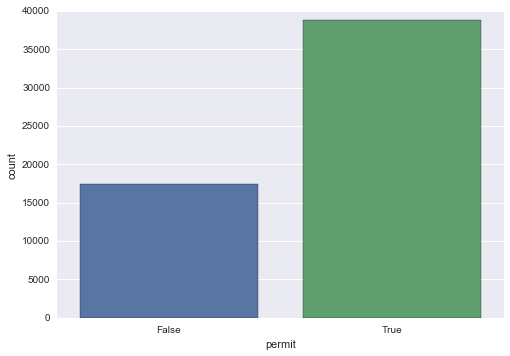

In [71]:
pd.set_option('display.max_columns', 25)
list_fields = ['status_group', ]
list_fields.extend(categorical_predictors)
list_fields.extend(('public_meeting', 'permit'))
for field in list_fields:
    display_markdown("### {} distribution".format(' '.join(field.split('_')).capitalize()), 
                     raw=True)
    display(data[field].value_counts(dropna=False).to_frame().T)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax = sns.countplot(field, data=data, ax=ax)
    lbls = ax.get_xticklabels()
    if len(lbls) > 7:
        ax.set_xticklabels(lbls, rotation=90)
    plt.show()

## Quantitative variable distribution

## Amount tsh distribution

,count,mean,std,min,25%,50%,75%,max
amount_tsh,17761.0,1062.351942,5409.34494,0.2,50.0,250.0,1000.0,350000.0


C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


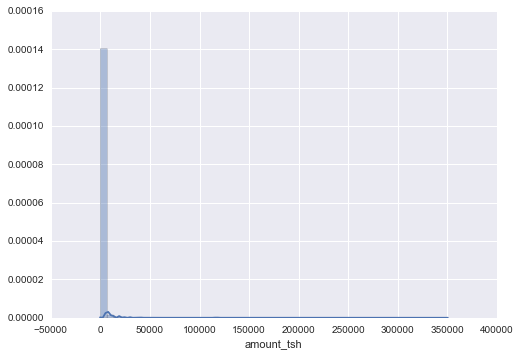

## Gps height distribution

,count,mean,std,min,25%,50%,75%,max
gps_height,38962.0,1018.860839,612.566092,-90.0,393.0,1167.0,1498.0,2770.0


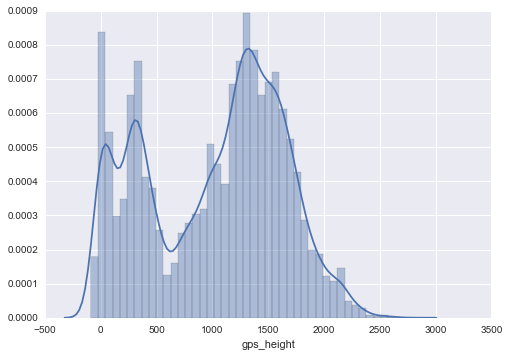

## Latitude distribution

,count,mean,std,min,25%,50%,75%,max
latitude,59400.0,-5.706033,2.946019,-11.64944,-8.540621,-5.021597,-3.326156,-2.000000e-08


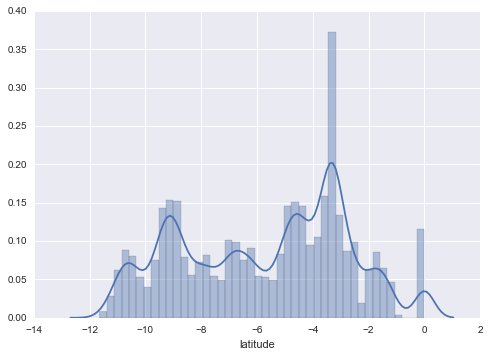

## Longitude distribution

,count,mean,std,min,25%,50%,75%,max
longitude,57588.0,35.149669,2.607428,29.607122,33.2851,35.005943,37.233712,40.345193


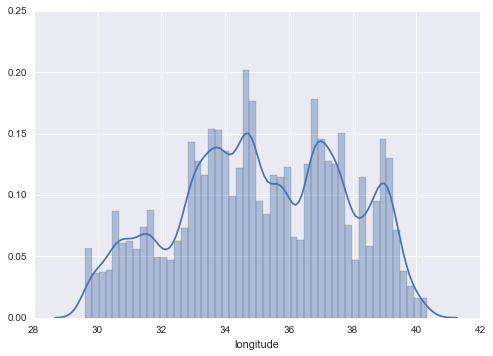

## Construction year distribution

,count,mean,std,min,25%,50%,75%,max
construction_year,38691.0,1996.814686,12.472045,1960.0,1987.0,2000.0,2008.0,2013.0


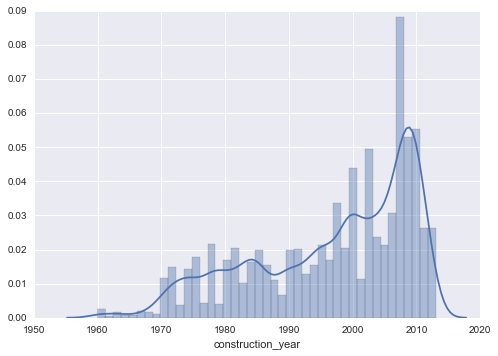

## Population distribution

,count,mean,std,min,25%,50%,75%,max
population,38019.0,281.087167,564.68766,1.0,40.0,150.0,324.0,30500.0


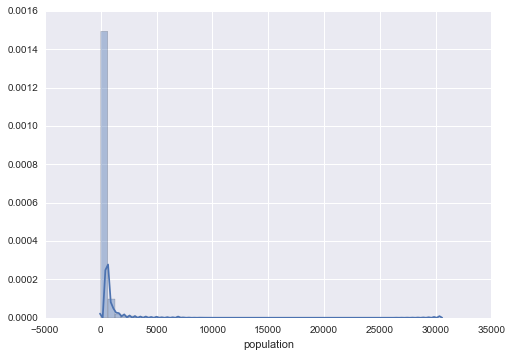

In [77]:
for field in ('amount_tsh', 'gps_height', 'latitude', 'longitude', 'construction_year', 'population'):
    display_markdown("### {} distribution".format(' '.join(field.split('_')).capitalize()), 
                     raw=True)
    clean_field = training_data[field].map(lambda x: x if abs(x)>1e-8 else pd.np.nan)
    clean_field = clean_field.dropna()
    display(clean_field.describe().to_frame().T)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax = sns.distplot(clean_field)
    plt.show()

# Bivariate distribution

In [219]:
# fit an Extra Trees model to the data
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
model.fit(predictors, clean_data['status'])
# display the relative importance of each attribute
cm = sns.light_palette("yellow", as_cmap=True)
(pd.Series(model.feature_importances_, index=predictors.columns, name='importance')
   .sort_values(ascending=False)
   .to_frame()
   .style.background_gradient(cmap=cm))